# Post Match

In [158]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

import impedance_calibration.stochastic_optimization as stochastic_optimization
from network.src import modeling_turns

## ODS

In [159]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))

# Network Import

In [160]:
current_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network') 
improvements = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements',ignore_geometry=True)
future_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network',ignore_geometry=True)
#TODO can only do this because no new network links were added
links = pd.merge(current_links,future_links[['linkid','reverse_link','multiplier','link_cost']],on=['linkid','reverse_link'])
links.rename(columns={'link_cost_x':'current_link_cost','link_cost_y':'future_link_cost','multiplier_x':'current_multiplier','multiplier_y':'future_multiplier'},inplace=True)
links = pd.merge(links,improvements,on='linkid',how='left')

print(current_links.shape)
print(future_links.shape)
print(links.shape)
print(improvements.shape)

(144458, 6)
(144458, 5)
(145064, 10)
(939, 3)


In [161]:
# del current_links
# del improvements
# del future_links

In [162]:
improvements.facility_fwd_new.value_counts()

multi use path    654
bike lane         285
Name: facility_fwd_new, dtype: int64

# Get link impedance reduction from improvements

In [163]:
print(links['coa_id'].nunique(),'unique projects')

38 unique projects


<AxesSubplot: >

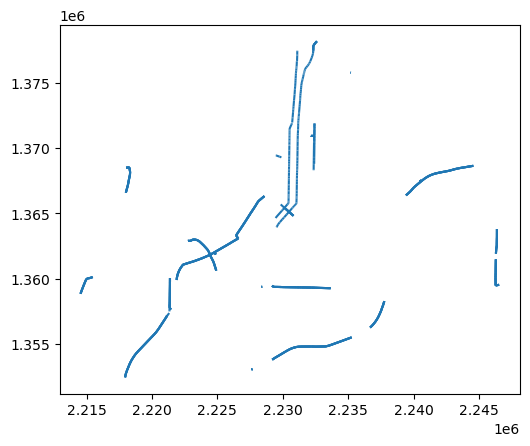

In [164]:
links[links['coa_id'].notna()].plot()

In [165]:
links['impedance_reduction'] = links['future_multiplier'] - links['current_multiplier']

In [166]:
#take the one with the max reduction
links['impedance_reduction'].describe()

count    145064.000000
mean         -0.004423
std           0.043853
min          -0.562000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: impedance_reduction, dtype: float64

In [167]:
max_impedance_reduction = links[links['impedance_reduction']<0].groupby('linkid')['impedance_reduction'].idxmin()
link_impedance_reduction = links.loc[max_impedance_reduction]
link_impedance_reduction.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='link_impedance_reduction')

In [168]:
undirected_links = links[links['reverse_link']==False]

# Import Routing Results

In [169]:
with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('rb') as fh:
    shortest_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"current_results.pkl").open('rb') as fh:
    current_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"future_results.pkl").open('rb') as fh:
    future_results_dict = pickle.load(fh)

In [170]:
travel_time_dict = dict(zip(links['linkid'],links['travel_time_min']))

current_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in current_results_dict.items()}
future_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in future_results_dict.items()}
shortest_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in shortest_results_dict.items()}

od_matrix['current_tt_min'] = [current_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_tt_min'] = [future_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['shortest_tt_min'] = [shortest_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

## Impedance Change for trips

In [171]:
current_impedance = {key:item['length'] for key, item in current_results_dict.items()}
future_impedance = {key:item['length'] for key, item in future_results_dict.items()}

od_matrix['current_impedance'] = [current_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_impedance'] = [future_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

In [172]:
reduction = (od_matrix['current_impedance'] - od_matrix['future_impedance'])

In [173]:
maen_reduction = (reduction * od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f'The average reduction in impedance was {round(maen_reduction,2)} minutes')

The average reduction in impedance was 0.15 minutes


In [174]:
max_reduction = reduction.max() #* od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f"The max reduction in impedance was {round(max_reduction,2)} minutes")

The max reduction in impedance was 6.9 minutes


<AxesSubplot: >

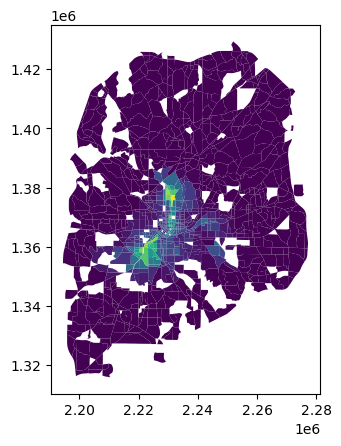

In [175]:
test = od_matrix.groupby('orig_taz').apply(lambda x: (x.current_impedance-x.future_impedance).mean())
studyarea = gpd.read_file(config['studyarea_fp'])
tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons',mask=studyarea)
tazs['impedance_change'] = tazs['tazid'].map(test)
tazs.plot('impedance_change')

In [176]:
tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='impedance_change')

# Percent Detour

In [185]:
od_matrix['percent_detour'] = ((od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
od_matrix['percent_detour']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
126636    0.000000
126637    0.000000
126638    1.886626
126639    0.000000
126640    0.000000
Name: percent_detour, Length: 126641, dtype: float64

In [187]:
percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.percent_detour * x.trips).sum() / x.trips.sum())
percent_detour

orig_taz
222     0.772294
229     1.105470
230     0.229399
235     0.238541
236     0.087121
          ...   
2374    0.338137
3387    0.692108
3389    0.284636
3390    0.092758
3467    0.258056
Length: 1135, dtype: float64

## Betweenness Centrality
We need this to visualize how trips shifted and to detemrine the impedance reduction contribution of each project.

In [ ]:
#directed is number of trips by direction, undirected is combined number of trips
current_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
current_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
future_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
future_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}

dict_keys = list(set.union(set(current_results_dict.keys()),set(future_results_dict.keys())))
for od_pair in dict_keys:
    #get number of trips for that origin node and destinnation node
    o_check = od_matrix['orig_N']==od_pair[0]
    d_check = od_matrix['dest_N']==od_pair[1]
    num_trips = od_matrix.loc[o_check & d_check,'trips'].sum()
    
    #retreive the edge list
    current_modeled_edges = current_results_dict.get(od_pair,0)
    future_modeled_edges = future_results_dict.get(od_pair,0)
    
    #current
    if current_modeled_edges != 0:
        #retrieve the edge list
        current_modeled_edges = [tuple(x) for x in current_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in current_modeled_edges:
            current_directed_btw_centrality[edge] += num_trips
            current_undirected_btw_centrality[edge[0]] += num_trips
    #future
    if future_modeled_edges != 0:
        #retrieve the edge list
        future_modeled_edges = [tuple(x) for x in future_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in future_modeled_edges:
            future_directed_btw_centrality[edge] += num_trips
            future_undirected_btw_centrality[edge[0]] += num_trips

#only keep non_zero entries
current_undirected_btw_centrality = {key:item for key,item in current_undirected_btw_centrality.items() if item > 0}
current_directed_btw_centrality = {key:item for key,item in current_directed_btw_centrality.items() if item > 0}
future_undirected_btw_centrality = {key:item for key,item in future_undirected_btw_centrality.items() if item > 0}
future_directed_btw_centrality = {key:item for key,item in future_directed_btw_centrality.items() if item > 0}            

#turn to dataframe
# directed btw centrality useful for directed bike facilities
df1 = pd.DataFrame.from_dict(current_directed_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_directed_btw_centrality,orient='index',columns=['future_btw_centrality'])
directed_btw_centrality = pd.concat([df1,df2],ignore_index=False,axis=1)
directed_btw_centrality.fillna(0,inplace=True)

df1 = pd.DataFrame.from_dict(current_undirected_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_undirected_btw_centrality,orient='index',columns=['future_btw_centrality'])
undirected_btw_centrality = pd.concat([df1,df2],ignore_index=False,axis=1)
undirected_btw_centrality.fillna(0,inplace=True)
undirected_btw_centrality.reset_index(inplace=True)
undirected_btw_centrality.rename(columns={'index':'linkid'},inplace=True)

#calculate the change
directed_btw_centrality['change'] = directed_btw_centrality['future_btw_centrality'] - directed_btw_centrality['current_btw_centrality']
undirected_btw_centrality['change'] = undirected_btw_centrality['future_btw_centrality'] - undirected_btw_centrality['current_btw_centrality']

#and pct change
undirected_btw_centrality['pct_change'] = undirected_btw_centrality['change'] / undirected_btw_centrality['current_btw_centrality'] * 100


In [ ]:
#add geometry data
undirected_btw_centrality_gdf = pd.merge(undirected_btw_centrality,undirected_links,on='linkid')
undirected_btw_centrality_gdf = gpd.GeoDataFrame(undirected_btw_centrality_gdf,geometry='geometry',crs=config['projected_crs_epsg'])

### Layer 1: Links with no trips

In [ ]:
no_trips = undirected_links.loc[undirected_links['linkid'].isin(set(undirected_btw_centrality_gdf['linkid'].tolist()))==False]
no_trips.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='no betweenness centrality')

### Layer 2: Links with no change in trips

In [ ]:
no_change = undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['change']==0]
no_change.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='no change betweenness centrality')

### Layer 3: Change in btwn centrality

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['change']!=0].plot('change')

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['pct']!=0].plot('change')

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['change']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='change_btwn_centrality')

## Impedance Reduction Contribution 

### Method 1: Multiply Link Impedance Reduction by Betweenness Centrality for the Improved Links

In [ ]:
links.columns

In [ ]:
# need impedance change

In [ ]:
undirected_links

In [ ]:
improvements.head()

In [ ]:
undirected_btw_centrality_gdf.head()

In [ ]:
test = pd.merge(test,facility_ids,on='linkid',how='left')

In [ ]:
test['impedance_change_cont'] = test['counts'] * test['impedance_change']

In [ ]:
#import the coa id back in so that we can aggregate by the faciility
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')[['coa_id','linkid']]

In [ ]:
result = test[test['impedance_change_cont']>0].groupby(['coa_id','improvement'])['impedance_change_cont'].sum().sort_values(ascending=False)
result.reset_index(inplace=True)

In [ ]:
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')
facility_ids = facility_ids.dissolve('coa_id').reset_index()

In [ ]:
facility_ids = pd.merge(facility_ids,result,on='coa_id')
facility_ids.explore('impedance_change_cont')

In [ ]:
results_dict

In [ ]:
#od_matrix['current_impedance'] = 
results_dict.apply(lambda x: current_results_dict.get((x['origin_N'],),axis=1)

In [ ]:
# find the impedance for each trip

In [ ]:
results_dict[(6846937343, 5416049647)].keys()

In [ ]:
#figure out why this is na
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
len(results_dict)

In [ ]:
# get the results and assigned to ods (store edge sequence in a dict soemwehre)
ods.map(results_dict)

In [ ]:
# calculate btwn centrality



In [ ]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)